# Introduction to Pandas for Quantitative Trading - For Excel Users

This notebook is designed for Excel users who are interested in quantitative trading and want to leverage the power of Python and Pandas to make their trading analysis more efficient and powerful.

### Why Use Pandas for Trading?
Pandas provides an excellent platform to handle time series data, perform technical analysis, backtest trading strategies, and much more. Compared to Excel, Pandas allows you to process large amounts of data quickly and gives you programmatic control over your analysis.

Throughout this notebook, we'll demonstrate how to use Pandas for various tasks in quantitative trading, from importing stock data to performing technical analysis and backtesting.


In [ ]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Fetching Stock Data for Analysis

We will use `yfinance` to download historical stock data for a popular stock, **Tesla (TSLA)**. This is similar to importing external data into Excel.

Let's fetch the data for the year 2023 so far.

```python
# Fetching stock data for Tesla
tsla_data = yf.download('TSLA', start='2023-01-01', end='2023-12-31')
```


In [ ]:
ticker = 'AAPL'
tsla_data = yf.download(ticker, period='max') # get the full history
info = yf.Ticker(ticker).info
bid_ask_spread = (info['ask'] / info['bid'] - 1)
bid_ask_spread
factor = (1 - bid_ask_spread) / (1 + bid_ask_spread)

[*********************100%***********************]  1 of 1 completed


# Investigating over-night and intra-day returns

In [ ]:
intraday_returns = tsla_data['Close'] / tsla_data['Open'] - 1
overnight_returns = tsla_data['Open'] / tsla_data['Close'].shift(1) - 1
close_to_close_returns = tsla_data['Close'].pct_change()
verify = (1 + intraday_returns) * (1 + overnight_returns) - 1 - close_to_close_returns

In [ ]:
verify

In [ ]:
cum_close_close_returns = (1 + close_to_close_returns).cumprod().fillna(1)
intraday_shortsell_returns = ((1 - intraday_returns) * factor ).cumprod().fillna(1)
cum_overnight_returns = (factor * (1 + overnight_returns)).cumprod().fillna(1)
all_returns = pd.concat([cum_close_close_returns, intraday_shortsell_returns, cum_overnight_returns], axis=1)
all_returns.columns = ['Close-to-Close Returns', 'Intraday Returns', 'Overnight Returns']

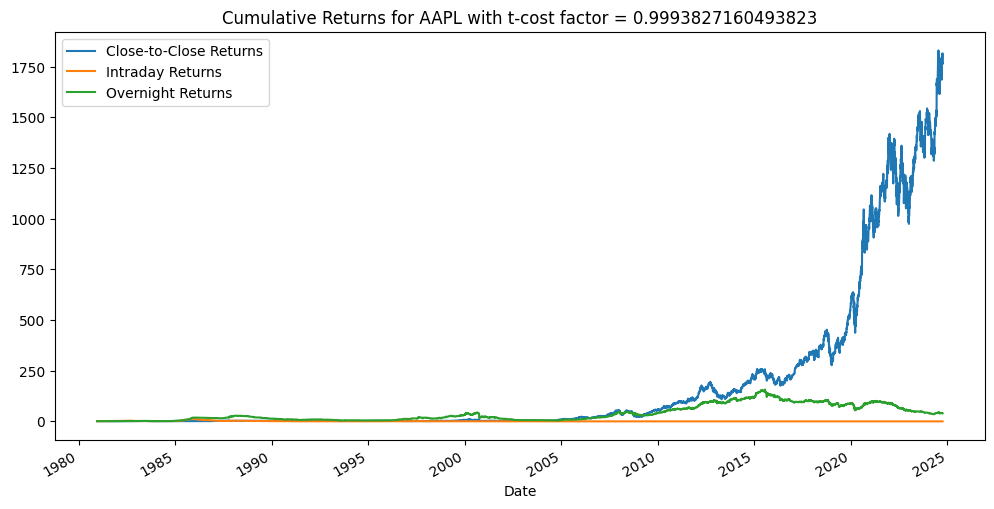

<Figure size 640x480 with 0 Axes>

In [ ]:
all_returns.plot(title=f'Cumulative Returns for {ticker} with t-cost factor = {factor}', figsize=(12, 6))
plt.show()
plt.savefig(f'cumulative_returns_{ticker}_{factor}.png')

In [ ]:
all_returns

,Close-to-Close Returns,Intraday Returns,Overnight Returns
Date,,,
2010-06-29,1.000000,1.257368,1.000000
2010-06-30,0.997489,1.161811,1.079531
2010-07-01,0.919213,1.020534,1.132533
2010-07-02,0.803683,0.851925,1.186168
2010-07-06,0.674341,0.686225,1.235592
...,...,...,...
2024-09-26,159.619056,0.644788,311.264970
2024-09-27,163.537007,0.652504,315.134054
2024-09-30,164.271632,0.659028,313.415998


# Dynamic Porfolio strategies

## Dynamic trading can be tricky. Let $W_t$ be the wealth on our brokerage account at time $t.$ We would like to buy $x_t$ shares at a price-per-share $P_t$. Then,
$$
W_t\ =\ \underbrace{x_tP_t}_{stock\ investment}\ +\ \underbrace{(W_t-x_tP_t)}_{cash}.
$$
# Next period, time $t+1$, we get
$$
W_{t+1}\ =\ \underbrace{x_tP_{t+1}}_{stock\ investment}\ +\ \underbrace{(1+r_f)}_{risk\ free\ rate}\underbrace{(W_t-x_tP_t)}_{cash}.
$$
# Open the brackets:
$$
W_{t+1}\ =\ x_tP_{t+1}+(1+r_f)W_t-(1+r_f)x_tP_t\ =\
$$
$$
=\ x_tP_{t+1}-(1+r_f)x_tP_t+(1+r_f)W_t\ =\
$$
$$
=\ x_t (P_{t+1}-(1+r_f)P_t)+(1+r_f)W_t
$$
#Let us divide this identity by $W_t,$
$$
\frac{W_{t+1}}{W_t}\ =\ \frac{x_t (P_{t+1}-(1+r_f)P_t)}{W_t}+\frac{(1+r_f)W_t}{W_t}
$$
#so that
$$
\frac{W_{t+1}}{W_t}\ =\ \frac{x_t (P_{t+1}-(1+r_f)P_t)}{W_t}\ +\ (1+r_f)
$$
#Let us now divide by $P_t:$
$$
\frac{W_{t+1}}{W_t}\ =\ \frac{x_tP_t (P_{t+1}/P_t-(1+r_f)P_t/P_t)}{W_t}\ +\ (1+r_f)
$$
#that is
$$
\frac{W_{t+1}}{W_t}\ =\ \frac{x_tP_t (R_{t+1}+1-(1+r_f))}{W_t}\ +\ (1+r_f)
$$
#where we have defined the returns,
$$
R_{t+1}+1\ =\ P_{t+1}/P_t\,.
$$
#We can now rewrite this as
$$
\frac{W_{t+1}}{W_t}\ =\ \frac{x_tP_t}{W_t}(R_{t+1}+1-(1+r_f))\ +\ (1+r_f),
$$
#Let
$$
\pi_t\ =\ \frac{x_tP_t}{W_t}
$$
# be the fraction of wealth invested into stock. Then, we get
$$
\underbrace{\frac{W_{t+1}}{W_t}-(1+r_f)}_{excess\ return\ on\ wealth}\ =\ \underbrace{\pi_t}_{portfolio\ weight}\underbrace{(R_{t+1}-r_f)}_{stock\ excess\ return}
$$
# Thus, your wealth evolves as
$$
W_{t+1}\ =\ W_t\,(1+r_f+\pi_t(R_{t+1}-r_f))
$$
# We can cumulate this by building cumulative returns

# The simplest strategy is $\pi_t=1$ (Buy-and-Hold):
$$
W_{t+1}\ =\ W_t\,(1+r_f+1\cdot(R_{t+1}-r_f))\ =\ W_t(1+R_{t+1})\ =\ W_t\,\frac{P_{t+1}}{P_t}
$$
# Quant trading is about finding  **dynamic** trading strategies that specify portfolio weights $\pi_t$ as a function of the information available at time $t$. We need to find smart ways and ideas on how to build **trading signals** from which we construct $\pi_t.$

#One class of such signals are related to **trend following** based on the simple idea: If the price went up, it will keep going up. One of the most popular signals in trend-following is based on **moving averages.**

## Calculating Moving Averages

One of the most common indicators used in trading is the **moving average**. Let's calculate the 20-day and 50-day moving averages of the closing price.

```python
# Calculate 20-day and 50-day moving averages
tsla_data['MA20'] = tsla_data['Close'].rolling(window=20).mean()
tsla_data['MA50'] = tsla_data['Close'].rolling(window=50).mean()

# Display data with moving averages
tsla_data[['Close', 'MA20', 'MA50']].tail()
```

In Excel, you might calculate this by adding a formula like `=AVERAGE(B2:B21)` in a new column. Pandas allows you to perform this operation quickly across all rows.


In [ ]:
tmp = pd.concat([tsla_data['Close'], tsla_data['Close'].rolling(window=2).mean()], axis=1)

In [ ]:
tmp1 = tsla_data['Close'].ewm(span=2).mean()
tmp = pd.concat([tmp, tmp1], axis=1)
tmp

,Close,Close,Close
Date,,,
2010-06-29,1.592667,NaN,1.592667
2010-06-30,1.588667,1.590667,1.589667
2010-07-01,1.464000,1.526334,1.502667
2010-07-02,1.280000,1.372000,1.352367
2010-07-06,1.074000,1.177000,1.166022
...,...,...,...
2024-09-26,254.220001,255.619995,254.545255
2024-09-27,260.459991,257.339996,258.488413
2024-09-30,261.630005,261.044998,260.582808


In [ ]:
# Calculate 20-day and 50-day moving averages
tsla_data['MA20'] = tsla_data['Close'].ewm(span=20).mean()
tsla_data['MA50'] = tsla_data['Close'].ewm(span=50).mean()
# tsla_data['MA20'] = tsla_data['Close'].rolling(window=20).mean()
# tsla_data['MA50'] = tsla_data['Close'].rolling(window=50).mean()
# Display data with moving averages
tsla_data[['Close', 'MA20', 'MA50']].tail()

,Close,MA20,MA50
Date,,,
2024-09-26,254.220001,234.589877,223.737154
2024-09-27,260.459991,237.053698,225.177265
2024-09-30,261.630005,239.394298,226.606784
2024-10-01,258.019989,241.168174,227.838675
2024-10-02,249.020004,241.915967,228.669315


In [ ]:
tsla_data['Close'].resample('W').last()


,Close
Date,
2010-07-04,1.280000
2010-07-11,1.160000
2010-07-18,1.376000
2010-07-25,1.419333
2010-08-01,1.329333
...,...
2024-09-08,210.729996
2024-09-15,230.289993
2024-09-22,238.250000


## Plotting Moving Averages

Visualizing data is crucial in trading analysis. Let’s plot the closing price and the moving averages to see how they compare over time.

```python
# Plot Closing Price and Moving Averages
tsla_data[['Close', 'MA20', 'MA50']].plot(title='TSLA Closing Price & Moving Averages', figsize=(12, 6))
plt.show()
```


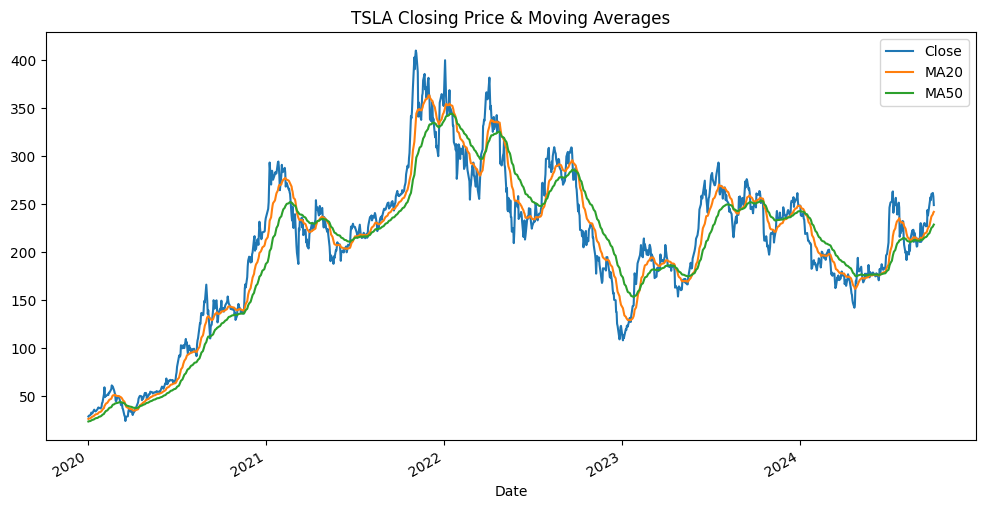

In [ ]:
# Plot Closing Price and Moving Averages
tsla_data[['Close', 'MA20', 'MA50']].loc['2020-01-01':].plot(title='TSLA Closing Price & Moving Averages', figsize=(12, 6))
plt.show()

## Generating Trading Signals

A simple trading strategy is to buy when the short-term moving average crosses above the long-term moving average (a **Golden Cross**) and sell when the short-term crosses below the long-term (a **Death Cross**).

Let's add signals to our data:

In [ ]:
# Create a 'Signal' column
tsla_data['Signal'] = 0
tsla_data.loc[tsla_data['MA20'] > tsla_data['MA50'], 'Signal'] = 1  # Buy signal
tsla_data.loc[tsla_data['MA20'] < tsla_data['MA50'], 'Signal'] = -1  # Sell signal

# Display signals
tsla_data[['Close', 'MA20', 'MA50', 'Signal']].tail()

,Close,MA20,MA50,Signal
Date,,,,
2024-09-26,254.220001,234.589877,223.737154,1
2024-09-27,260.459991,237.053698,225.177265,1
2024-09-30,261.630005,239.394298,226.606784,1
2024-10-01,258.019989,241.168174,227.838675,1
2024-10-02,249.020004,241.915967,228.669315,1


## Backtesting the Strategy

Now that we have our trading signals, let's calculate the returns of our strategy and compare it with simply holding the stock.

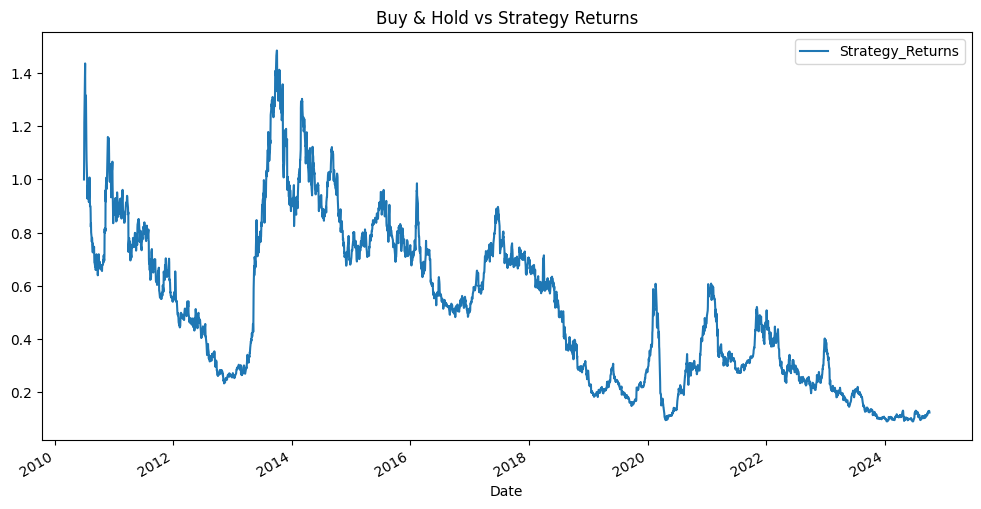

In [ ]:
# Calculate daily returns
tsla_data['Returns'] = tsla_data['Close'].pct_change()
tsla_data['OpenReturns'] = tsla_data['Open'].pct_change()

# Calculate strategy returns
portfolio_weight = tsla_data['Signal']

# We are assuming r_f = 0, so strategy returns are just \pi_t * R_{t+1}
tsla_data['Strategy_Returns'] = tsla_data['Returns'] * portfolio_weight.shift(1)

# Cumulative returns
(1 + tsla_data[['Strategy_Returns']]).cumprod().plot(title='Buy & Hold vs Strategy Returns', figsize=(12, 6))
plt.show()

In [ ]:
# the values of a Pandas dataframe are actually a numpy array
tsla_data['Returns'].values

array([        nan, -0.00251148, -0.07847274, ...,  0.0044921 ,
       -0.01379817, -0.03488096])

In [ ]:
class DynamicTrading:
    def __init__(self, prices):
        self.prices = prices
        self.returns = self.prices.pct_change()
    def moving_average_cross(self, window_short=20, window_long=50):
        ma_short = self.prices.ewm(span=window_short).mean()
        ma_long = self.prices.ewm(span=window_long).mean()
        signal = (ma_short > ma_long).astype(int) - (ma_short < ma_long).astype(int)
        return signal
    def strategy_returns(self, signal):
        # here, we use numpy broadcasting to build strategy returns for a whole dataframe of signals
        # numpy broadcasting understands that it needs to multiply all signals with returns
        strategy_returns = self.returns.values.reshape(-1, 1) * signal.shift(1)
        return strategy_returns

In [ ]:
short_windows = [1, 2, 5, 10, 20, 50, 100]
long_windows = [5, 10, 20, 50, 100, 200]

trading = DynamicTrading(tsla_data['Close'])
trading

In [ ]:
# list comprehension
signals = [trading.moving_average_cross(window_short=w1, window_long=w2) for w1 in short_windows for w2 in long_windows if w2 > w1]
signals

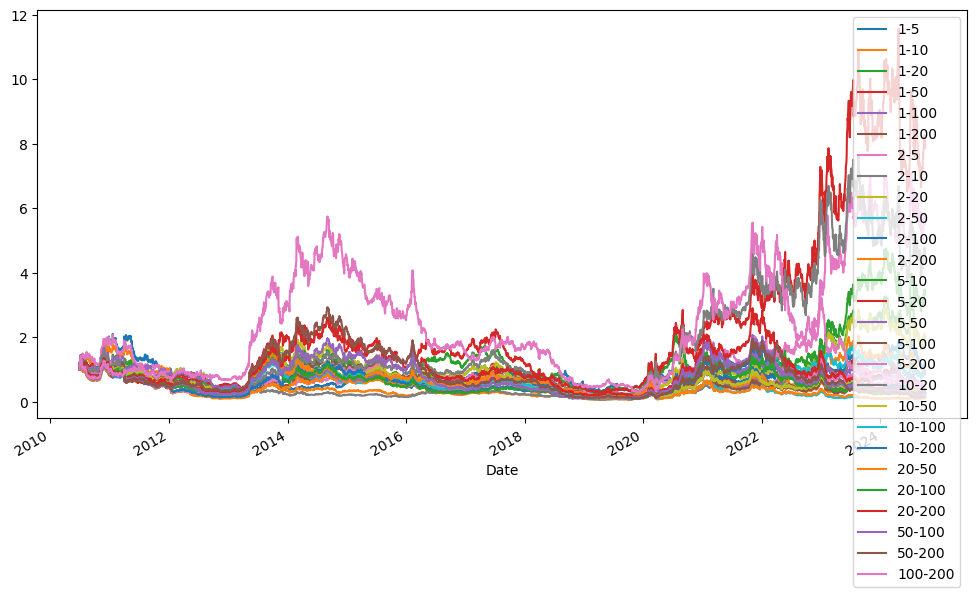

In [ ]:
signals = pd.concat(signals, axis=1)
signals.columns = [f'{w1}-{w2}' for w1 in short_windows for w2 in long_windows if w2 > w1]
ma_cross_returns = trading.strategy_returns(signals)

# remember the wealth evolves as W_{t+1} = (1 + strategy_return_{t+1}) * W_t
# cumprod function performs the cumulation of returns
(1 + ma_cross_returns).cumprod().plot(figsize=(12, 6))
plt.show()

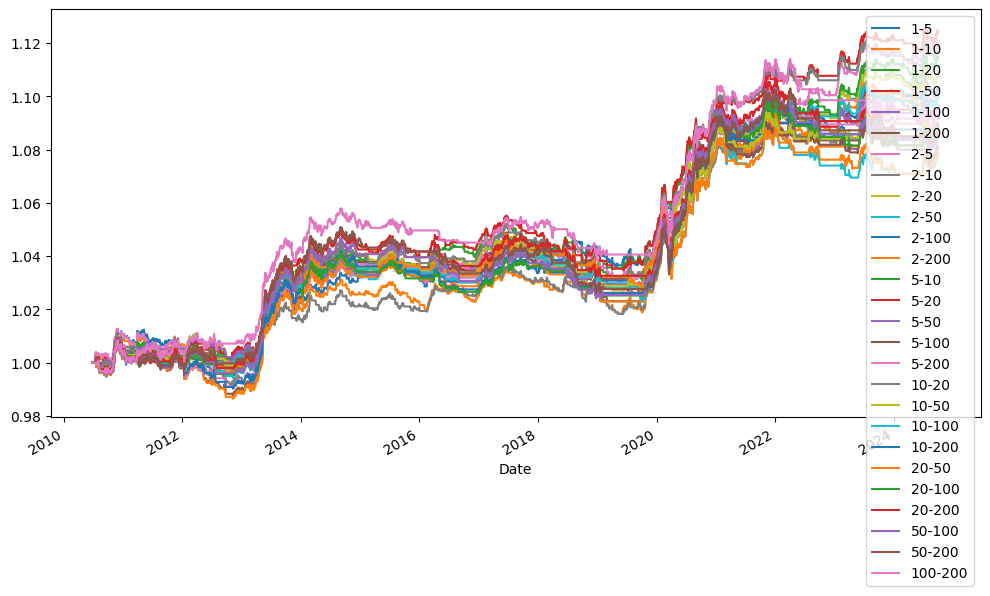

In [ ]:
leverage = 0.01
(1 + leverage * (ma_cross_returns + trading.returns.values.reshape(-1, 1))).cumprod().plot(figsize=(12, 6))
plt.show()

In [ ]:
import pandas as pd
# Step 1: Scrape the current list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read the tables on the Wikipedia page using pandas
tables = pd.read_html(url)

# The first table on the page contains the current S&P 500 components
sp500_table = tables[0]

# Get the list of current S&P 500 tickers
current_components = set(sp500_table['Symbol'].tolist())

In [ ]:
current_components

In [ ]:
len(current_components)

503

In [ ]:
import yfinance as yf
# Function to download full historical data for each ticker
def download_full_history(tickers):
    # Download full history data for all tickers
    data = yf.download(tickers, period="max")  # Downloads full historical data
    return data

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

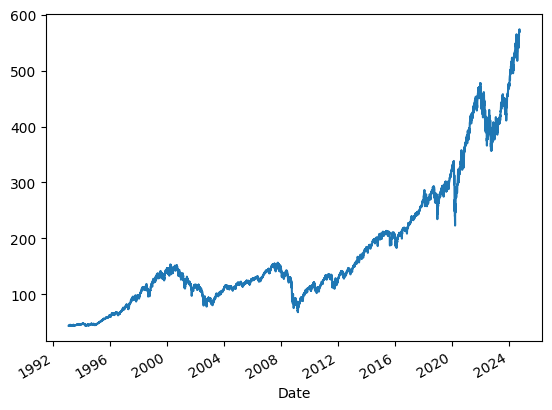

In [ ]:
sp500 = download_full_history(['SPY'])
sp500['Close'].plot()

In [ ]:
# let us get prices of all current components of SP500
all_data = download_full_history(current_components)

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-10-28 -> 2024-10-03)')


In [ ]:
all_data = all_data['Close']

<Axes: xlabel='Date'>

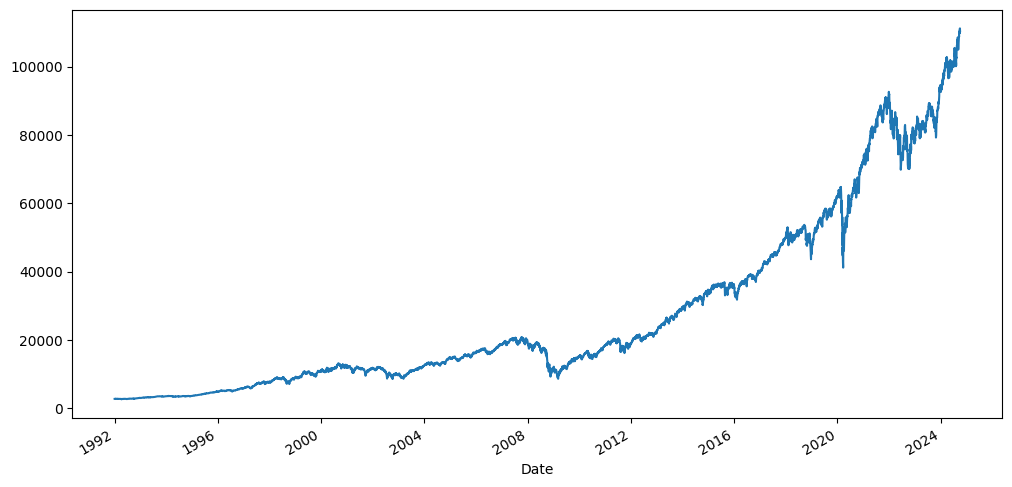

In [ ]:
all_data.loc['1992-01-01':].sum(1).plot(figsize=(12, 6))

In [ ]:
short_windows = [1, 2, 5, 10, 20, 50, 100]
long_windows = [5, 10, 20, 50, 100, 200]
aggregated_ma_cross_returns = pd.DataFrame()
for ticker in list(current_components):
  trading = DynamicTrading(all_data[ticker])
  signals = [trading.moving_average_cross(window_short=w1, window_long=w2) for w1 in short_windows for w2 in long_windows if w2 > w1]
  signals = pd.concat(signals, axis=1)
  signals.columns = [f'{w1}-{w2}' for w1 in short_windows for w2 in long_windows if w2 > w1]
  ma_cross_returns_new = trading.strategy_returns(signals)
  ma_cross_returns_new['long_only'] = trading.returns.values.reshape(-1, 1)
  if aggregated_ma_cross_returns.empty:
    aggregated_ma_cross_returns = ma_cross_returns_new.fillna(0)
  else:
    aggregated_ma_cross_returns += ma_cross_returns_new.fillna(0)



<ipython-input-1-3bd8b5faf42d>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change()
<ipython-input-1-3bd8b5faf42d>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change()
<ipython-input-1-3bd8b5faf42d>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change()


In [ ]:
aggregated_ma_cross_returns

,1-5,1-10,1-20,1-50,1-100,1-200,2-5,2-10,2-20,2-50,...,10-50,10-100,10-200,20-50,20-100,20-200,50-100,50-200,100-200,long_only
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1962-01-03 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034496
1962-01-04 00:00:00+00:00,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,...,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,0.118417,-0.091487
1962-01-05 00:00:00+00:00,0.212560,0.212560,0.212560,0.212560,0.212560,0.212560,0.172956,0.172956,0.172956,0.172956,...,0.172956,0.172956,0.172956,0.172956,0.172956,0.172956,0.172956,0.172956,0.172956,-0.329106
1962-01-08 00:00:00+00:00,0.089742,0.089742,0.089742,0.089742,0.089742,0.089742,0.089742,0.089742,0.089742,0.089742,...,0.130979,0.130979,0.130979,0.130979,0.130979,0.130979,0.130979,0.130979,0.130979,-0.097925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26 00:00:00+00:00,0.090790,1.278501,1.878129,1.118537,0.795582,0.430922,0.835466,1.487028,2.215243,1.265397,...,1.029379,0.324654,0.529645,0.298651,-0.147972,0.335295,-0.380573,0.388066,0.826332,4.204454
2024-09-27 00:00:00+00:00,-0.761597,-0.657274,-0.229006,-0.086448,-0.119636,-0.322850,-1.070078,-0.487777,-0.118438,-0.098346,...,0.269108,-0.104492,-0.572532,0.201917,0.005515,-0.451000,-0.337500,-0.644784,-0.663914,1.793643
2024-09-30 00:00:00+00:00,-1.037772,-0.900884,-0.457527,0.475394,0.921031,1.259192,-0.958194,-0.667331,-0.301106,0.453117,...,0.966820,1.213370,1.713164,1.170034,1.495727,1.802491,1.945676,1.830140,1.585731,0.935361


In [ ]:
import numpy as np
def annualized_sharpe_ratio(daily_returns):
    return np.sqrt(252) * daily_returns.mean() / daily_returns.std()

In [ ]:
srs = annualized_sharpe_ratio(0.1 * aggregated_ma_cross_returns['100-200'] + aggregated_ma_cross_returns['long_only'])
srs

0.7860997750108794

In [ ]:
# Step 2: Scrape the changes table from the same Wikipedia page
# Find the table with 'Date' in its columns
from collections import defaultdict
from datetime import timedelta
changes_table = None
for table in tables:
    if 'Date' in table.columns:
        changes_table = table
        break

if changes_table is None:
    raise ValueError('Could not find the "Changes in S&P 500 components" table on the Wikipedia page.')

# Clean and parse the changes table
changes_df = changes_table.copy()

# Rename columns for easier access
changes_df.columns = ['Date', 'Added Ticker', 'Added Security', 'Removed Ticker', 'Removed Security', 'Reason']

# Convert 'Date' column to datetime
changes_df['Date'] = pd.to_datetime(changes_df['Date'])

# Sort the DataFrame by date
changes_df = changes_df.sort_values('Date')

# Step 3: Build the historical list of components
components_by_month = defaultdict(set)

# Initialize with the current components for the latest month
latest_month = changes_df['Date'].max().replace(day=1)
components_by_month[latest_month] = current_components.copy()

# Apply the changes backward in time
for index, row in changes_df[::-1].iterrows():
    date = row['Date']
    month = date.replace(day=1)
    added_ticker = row['Added Ticker']
    removed_ticker = row['Removed Ticker']

    # Copy the components from the next month
    next_month = (month + timedelta(days=31)).replace(day=1)
    components = components_by_month.get(next_month, current_components).copy()

    # Apply the addition and deletion
    if pd.notna(added_ticker):
        components.add(added_ticker.strip())
    if pd.notna(removed_ticker):
        components.discard(removed_ticker.strip())

    # Store the updated components for the current month
    components_by_month[month] = components

# Fill in the missing months
all_months = pd.date_range(start=min(components_by_month.keys()), end=max(components_by_month.keys()), freq='MS')
for month in all_months:
    if month not in components_by_month:
        next_month = (month + timedelta(days=31)).replace(day=1)
        components_by_month[month] = components_by_month.get(next_month, current_components).copy()

# Convert the dictionary to a DataFrame
historical_components = pd.DataFrame([
    {'Month': month, 'Tickers': sorted(tickers)}
    for month, tickers in sorted(components_by_month.items())
])

# Reset index to ensure 'Month' is a column
historical_components.reset_index(drop=True, inplace=True)

# Display the historical components indexed by month
print(historical_components.head())


       Month                                            Tickers
0 1997-06-01  [A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE, AD...
1 1997-07-01  [A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE, AD...
2 1997-08-01  [A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE, AD...
3 1997-09-01  [A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE, AD...
4 1997-10-01  [A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE, AD...


In [ ]:
historical_components.iloc[0, 1]

['A',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMTM',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF.B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK.B',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'CTRA',
 '

# Transaction costs.


In [ ]:
import yfinance as yf
ticker = 'TSLA'
info = yf.Ticker(ticker).info
bid_ask_spread = info['ask'] / info['bid'] - 1
bid_ask_spread
industry = info['industry']
sector = info['sector']

In [ ]:
info

#Costs occur when we change the number of shares:
$$
W_t\ =\ {x_tP_t}\ +\ (W_t-x_tP_t)\ -\ c P_t |x_t-x_{t-1}|
$$
But
$$
\pi_t\ =\ x_tP_t/W_t
$$
#Thus, Costs are
$$
Costs=P_t |x_t-x_{t-1}|=|P_tx_t-P_tx_{t-1}|=|W_t\pi_t-(1+R_t)P_{t-1}x_{t-1}|=|W_t\pi_t-(1+R_t)\pi_{t-1}W_{t-1}|
$$
$$
 =\  W_{t-1} |(1+\pi_{t-1}R_t)\pi_t-(1+R_t)\pi_{t-1}|
$$
# and the realized return on the wealth is
$$
(1+\pi_{t-1}R_t)\ -\ c|(1+\pi_{t-1}R_t)\pi_t-(1+R_t)\pi_{t-1}|
$$
#Suppose $\pi=L.$ Then, the costs are
$$
|(1+L R_t)-(1+R_t)|L\ =\ |(L-1)R_t|L
$$

In [ ]:
class DynamicTrading:
    def __init__(self, prices):
        self.prices = prices
        self.returns = self.prices.pct_change()
    def moving_average_cross(self, window_short=20, window_long=50):
        ma_short = self.prices.rolling(window=window_short).mean()
        ma_long = self.prices.rolling(window=window_long).mean()
        signal = (ma_short > ma_long).astype(int) - (ma_short < ma_long).astype(int)
        return signal
    def strategy_returns(self, signal, cost):
        # here, we use numpy broadcasting to build strategy returns for a whole dataframe of signals
        # numpy broadcasting understands that it needs to multiply all signals with returns
        strategy_returns = self.returns.values.reshape(-1, 1) * signal.shift(1)
        t_costs = (signal * (1 + strategy_returns.values.reshape(-1, 1)) - signal.shift(1) * (1 + self.returns.values.reshape(-1, 1))).abs() * cost
        strategy_returns = strategy_returns - t_costs
        return strategy_returns


In [ ]:
ticker = 'AAPL'
data = download_full_history([ticker])
data = data['Close']
trading = DynamicTrading(data)

info = yf.Ticker(ticker).info
bid_ask_spread = info['ask'] / info['bid'] - 1
leverage = 0.1
portfolio_weights = 0.1 + 0 * pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SR = Close    0.607529\ndtype: float64'}, xlabel='Date'>

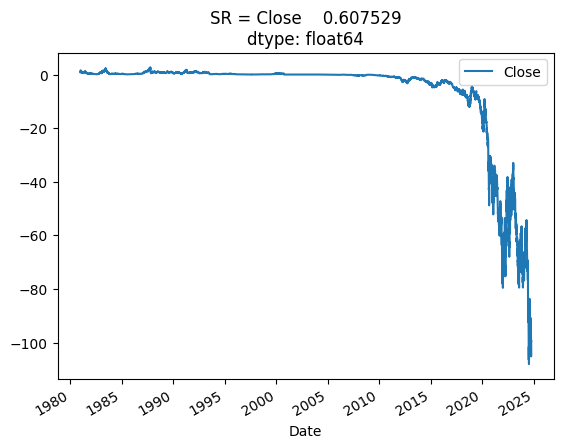

In [ ]:
rets = trading.strategy_returns(portfolio_weights, cost=bid_ask_spread)

(1+rets).cumprod().plot(title=f'SR = {annualized_sharpe_ratio(rets)}')

<Axes: xlabel='Date'>

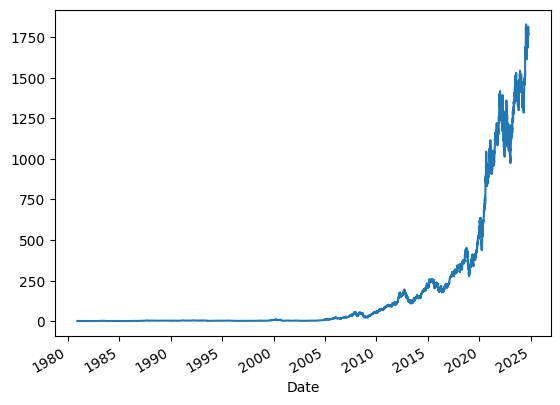

In [ ]:
(1+trading.returns).fillna(1).cumprod().plot()